# Packages & Includes

In [1]:
using Plots
using StatsBase
using LinearAlgebra
using Statistics
using JLD2
using Dates
using LsqFit
using StaticArrays

# data structure module (needs to be module to avoid overwriting local variables in REPL scope)
include("SpinSimParams.jl")
using .SpinSimParams

# function libraries
include("spin_sims.jl");

# Parameters

In [3]:
# spin operators
#Ix = @SMatrix [0 1/2; 1/2 0];
#Iy = @SMatrix [0 -1im/2; 1im/2 0];
#Iz = @SMatrix [1/2 0; 0 -1/2];
#M_op = Ix + 1im*Iy;

# gamma
γ = 2*π*1e6;

# time variables
τ = 100e-6;
dt = 2;

# pulse operators
#UL90 = exp(-1im*pi*Ix/2);
#UR90 = exp(1im*pi*Ix/2);

# interaction
α = 0.1#[0.10,0.14,0.18]; # [0.1, 0.2, 0.3, 0.4];
ω = 0.0#[0.000,0.001,0.005,0.01,0.1]; # [0, 0.001, 0.005];

# spin ensemble
ν0 = 10;
bw = 0.5;
dfreq = 0.002;

# initial conditions
dim = 2;
ψ_0 = @SArray [1 0];
ρ_temp = [ψ_0[i]*ψ_0[j] for i = 1:dim, j = 1:dim];

ρ0 = @SMatrix [ρ_temp[1,1] ρ_temp[1,2]; ρ_temp[2,1] ρ_temp[2,2]];

# Create Parameter File

In [115]:
params = make_parameters(γ, τ, dt, α, ω, ν0, bw, dfreq, ρ0);

nx = 22
ny = 22
nz = 22

ξ_list = [0.1, 0.5, 1, 5, 10, 9999] # correlation length, in units of lattice parameter
M_stencil_list = []
for ξ in ξ_list
    M_stencil = zeros(nx,ny,nz)

    for a = 1:nx
        for b = 1:ny
            for c = 1:nz
                a_loc = mod(a-1+nx/2,nx) - nx/2
                b_loc = mod(b-1+ny/2,ny) - ny/2
                c_loc = mod(c-1+nz/2,nz) - nz/2

                r_loc = [a_loc, b_loc, c_loc]
                M_stencil[a,b,c] = 1/(norm(r_loc)/ξ+1)

            end
        end
    end

    M_stencil = M_stencil./sum(M_stencil)
    #M_stencil[1,1,1] = 0 # no onsite correlation
    push!(M_stencil_list,M_stencil)
end

params.int_sample = false
params.nS = nx*ny*nz
params.M_stencil = M_stencil_list

#vars = ["α"];
vars = ["M_stencil"];


# Run the Simulation

In [116]:
I, d = make_idx(vars, params)
M_list = Array{Any}(undef, d)

for i in I
    println(i) # print loop index for gauging speed locally
    tparams = temp_parameters(params, vars, i)
    @time M_list[i] = spin_echo_sim_localM(tparams)
end

# @save "001_M_list.jld2" M_list
# @save "001_parameters.jld2" params

1
418.348041 seconds (751.94 M allocations: 1.600 TiB, 5.16% gc time)
2
414.563675 seconds (751.94 M allocations: 1.600 TiB, 5.18% gc time)
3
408.576659 seconds (751.94 M allocations: 1.600 TiB, 5.24% gc time)
4
406.830153 seconds (751.94 M allocations: 1.600 TiB, 5.26% gc time)
5
407.069560 seconds (751.94 M allocations: 1.600 TiB, 5.20% gc time)
6
408.207630 seconds (751.94 M allocations: 1.600 TiB, 5.19% gc time)


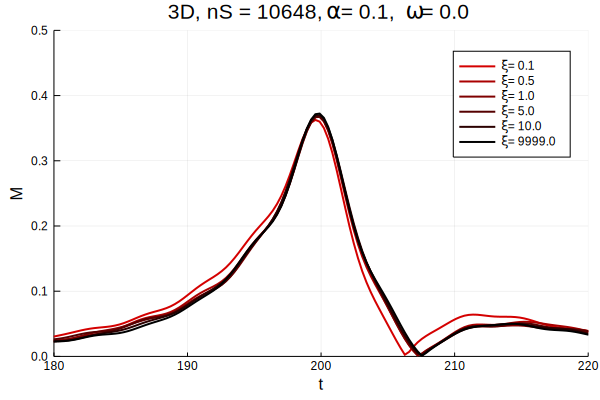

(6,)


In [119]:
using LaTeXStrings

plot_dim = 3
plt1 = plot()
println(size(M_list))

#M_inf = M_list[1]

for var1 = 1:6
    tar_M = M_list[var1]
    t = LinRange(0, 300, size(tar_M, 1));
    #y_shift = 0*0.4*(6-var1);
    cidx = (6-var1)/6
    lc = RGB(cidx,0,0)
    plot!(t, broadcast(abs, tar_M),label=string(raw"\xi = ", ξ_list[var1]), lw=2,color=lc)
    #plot!(t,zeros(size(t)) .+ y_shift, color=RGB(0,0,0), linestyle = :dot, label="")
    #plot!(t, broadcast(abs, M_inf),label=string("a = ",α[var1],", w = ",ω[var2],", inf."), lw=2)
end
xaxis!("t")
yaxis!("M")
title!(string(plot_dim,"D, nS = ",nx*ny*nz,raw", \alpha = ",α,raw", \omega = ",ω))
xlims!(180,220)
ylims!(0,0.5)
display(plt1);


#tparams = temp_parameters(params, vars, I[1])
#params_new = make_parameters(γ, τ, dt, α, ω, ν0, bw, dfreq, ρ0);
#params_new.int_sample = true
#tparams_new = temp_parameters(params_new, vars, I[1])
#histogram(tparams.ν,bins=range(9.75,stop=10.25,length=250))
#plot!(tparams_new.ν,20*lorentzian.(tparams_new.ν,tparams_new.ν0, 0.05))
fname = "correlation_3d_test"
#savefig(plt1,fname)

# testing area

In [121]:
nx = 4
ny = 4
nz = 1

M_stencil = zeros(nx,ny,nz)
M_stencil[1,1,1] = 1
M_stencil[2,1,1] = 0.5
M_stencil[nx,1,1] = 0.5
M_stencil[1,2,1] = 0.5
M_stencil[1,ny,1] = 0.5



spin_idx = 12

tar_loc_mat = zeros(nx*ny*nz,1)

tar_loc_mat[spin_idx] = 1
tar_loc_mat = reshape(tar_loc_mat, (nx,ny,nz))
target_vec = (findall(x->x==1, tar_loc_mat)[1])
shift_vec = zeros(3)
shift_vec[1] = target_vec[1]-1
shift_vec[2] = target_vec[2]-1
shift_vec[3] = target_vec[3]-1
println(shift_vec )
M_new = circshift(M_stencil, shift_vec)
#reshape(M_new, (nx*ny*nz,1) )



[3.0, 2.0, 0.0]


4×4×1 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.5  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0
 0.0  0.5  1.0  0.5

In [30]:
fprefix = "test_run_06-16-2020"
#@save string(fprefix,"_data.jld2") M_list params
#@save string(fprefix,"_M_list.jld2") M_list
#@save string(fprefix,"_parameters.jld2") params

In [21]:
@load "test_run_06-16-2020_data.jld2" M_list params
#@load "test_run_06-16-2020_M_list.jld2"
#@load "test_run_06-16-2020_parameters.jld2"
